In [1]:
import glob
import sys
import os
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from functools import partial
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf


def data_load():
    files = glob.glob('../data/*')
    if not files:
        print("Chck Phath")
        sys.exit()
    else:
        files.remove(r'../data\raw_data')
        files.remove(r'../data\raw_data_')

    _feature=[]
    label=[]
    for address in files:
        label_ = os.path.basename(address)
        for num in glob.glob(address+'/*'):
            _feature.append(np.load(num))
            label.append([label_])
        print(label_)
    target = np.array(label).flatten()
    return _feature, target.reshape((-1,))

features, label = data_load()
encoder = LabelEncoder()
target = encoder.fit_transform(label)


X_train,  X_valid, y_train, y_valid = train_test_split(np.array(features), target, test_size=0.2, random_state=0)
X_test,  X_valid, y_test, y_valid = train_test_split(np.array(features), target, test_size=0.5, random_state=0)
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

y_test_raw = y_test.copy()
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
number_of_classes = y_valid.shape[1]


around
b
fracture
ground
mechanics
science
smile
strain
stress
t


In [14]:
from __future__ import print_function
import imageio
from PIL import Image
import numpy as np
import keras

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD
from pool_helper import PoolHelper
from lrn import LRN

if keras.backend.backend() == 'tensorflow':
    from keras import backend as K
    import tensorflow as tf
    from keras.utils.conv_utils import convert_kernel


def create_googlenet(weights_path=None):
    # creates GoogLeNet a.k.a. Inception v1 (Szegedy, 2015)
    input = Input(shape=(3, 224, 224))

    input_pad = ZeroPadding2D(padding=(3, 3))(input)
    conv1_7x7_s2 = Conv2D(64, (7,7), strides=(2,2), padding='valid', activation='relu', name='conv1/7x7_s2', kernel_regularizer=l2(0.0002))(input_pad)
    conv1_zero_pad = ZeroPadding2D(padding=(1, 1))(conv1_7x7_s2)
    pool1_helper = PoolHelper()(conv1_zero_pad)
    pool1_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool1/3x3_s2')(pool1_helper)
    pool1_norm1 = LRN(name='pool1/norm1')(pool1_3x3_s2)

    conv2_3x3_reduce = Conv2D(64, (1,1), padding='same', activation='relu', name='conv2/3x3_reduce', kernel_regularizer=l2(0.0002))(pool1_norm1)
    conv2_3x3 = Conv2D(192, (3,3), padding='same', activation='relu', name='conv2/3x3', kernel_regularizer=l2(0.0002))(conv2_3x3_reduce)
    conv2_norm2 = LRN(name='conv2/norm2')(conv2_3x3)
    conv2_zero_pad = ZeroPadding2D(padding=(1, 1))(conv2_norm2)
    pool2_helper = PoolHelper()(conv2_zero_pad)
    pool2_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool2/3x3_s2')(pool2_helper)

    inception_3a_1x1 = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_3a/1x1', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_3x3_reduce = Conv2D(96, (1,1), padding='same', activation='relu', name='inception_3a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3_reduce)
    inception_3a_3x3 = Conv2D(128, (3,3), padding='valid', activation='relu', name='inception_3a/3x3', kernel_regularizer=l2(0.0002))(inception_3a_3x3_pad)
    inception_3a_5x5_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_3a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
    inception_3a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5_reduce)
    inception_3a_5x5 = Conv2D(32, (5,5), padding='valid', activation='relu', name='inception_3a/5x5', kernel_regularizer=l2(0.0002))(inception_3a_5x5_pad)
    inception_3a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_3a/pool')(pool2_3x3_s2)
    inception_3a_pool_proj = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_3a/pool_proj', kernel_regularizer=l2(0.0002))(inception_3a_pool)
    inception_3a_output = Concatenate(axis=1, name='inception_3a/output')([inception_3a_1x1,inception_3a_3x3,inception_3a_5x5,inception_3a_pool_proj])

    inception_3b_1x1 = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_3b/1x1', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_3x3_reduce = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_3b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3_reduce)
    inception_3b_3x3 = Conv2D(192, (3,3), padding='valid', activation='relu', name='inception_3b/3x3', kernel_regularizer=l2(0.0002))(inception_3b_3x3_pad)
    inception_3b_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_3b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_3a_output)
    inception_3b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5_reduce)
    inception_3b_5x5 = Conv2D(96, (5,5), padding='valid', activation='relu', name='inception_3b/5x5', kernel_regularizer=l2(0.0002))(inception_3b_5x5_pad)
    inception_3b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_3b/pool')(inception_3a_output)
    inception_3b_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_3b/pool_proj', kernel_regularizer=l2(0.0002))(inception_3b_pool)
    inception_3b_output = Concatenate(axis=1, name='inception_3b/output')([inception_3b_1x1,inception_3b_3x3,inception_3b_5x5,inception_3b_pool_proj])

    inception_3b_output_zero_pad = ZeroPadding2D(padding=(1, 1))(inception_3b_output)
    pool3_helper = PoolHelper()(inception_3b_output_zero_pad)
    pool3_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool3/3x3_s2')(pool3_helper)

    inception_4a_1x1 = Conv2D(192, (1,1), padding='same', activation='relu', name='inception_4a/1x1', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_3x3_reduce = Conv2D(96, (1,1), padding='same', activation='relu', name='inception_4a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4a_3x3_reduce)
    inception_4a_3x3 = Conv2D(208, (3,3), padding='valid', activation='relu', name='inception_4a/3x3' ,kernel_regularizer=l2(0.0002))(inception_4a_3x3_pad)
    inception_4a_5x5_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_4a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
    inception_4a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4a_5x5_reduce)
    inception_4a_5x5 = Conv2D(48, (5,5), padding='valid', activation='relu', name='inception_4a/5x5', kernel_regularizer=l2(0.0002))(inception_4a_5x5_pad)
    inception_4a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4a/pool')(pool3_3x3_s2)
    inception_4a_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4a/pool_proj', kernel_regularizer=l2(0.0002))(inception_4a_pool)
    inception_4a_output = Concatenate(axis=1, name='inception_4a/output')([inception_4a_1x1,inception_4a_3x3,inception_4a_5x5,inception_4a_pool_proj])

    loss1_ave_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss1/ave_pool')(inception_4a_output)
    loss1_conv = Conv2D(128, (1,1), padding='same', activation='relu', name='loss1/conv', kernel_regularizer=l2(0.0002))(loss1_ave_pool)
    loss1_flat = Flatten()(loss1_conv)
    loss1_fc = Dense(1024, activation='relu', name='loss1/fc', kernel_regularizer=l2(0.0002))(loss1_flat)
    loss1_drop_fc = Dropout(rate=0.7)(loss1_fc)
    loss1_classifier = Dense(1000, name='loss1/classifier', kernel_regularizer=l2(0.0002))(loss1_drop_fc)
    loss1_classifier_act = Activation('softmax')(loss1_classifier)

    inception_4b_1x1 = Conv2D(160, (1,1), padding='same', activation='relu', name='inception_4b/1x1', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_3x3_reduce = Conv2D(112, (1,1), padding='same', activation='relu', name='inception_4b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4b_3x3_reduce)
    inception_4b_3x3 = Conv2D(224, (3,3), padding='valid', activation='relu', name='inception_4b/3x3', kernel_regularizer=l2(0.0002))(inception_4b_3x3_pad)
    inception_4b_5x5_reduce = Conv2D(24, (1,1), padding='same', activation='relu', name='inception_4b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4a_output)
    inception_4b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4b_5x5_reduce)
    inception_4b_5x5 = Conv2D(64, (5,5), padding='valid', activation='relu', name='inception_4b/5x5', kernel_regularizer=l2(0.0002))(inception_4b_5x5_pad)
    inception_4b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4b/pool')(inception_4a_output)
    inception_4b_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4b/pool_proj', kernel_regularizer=l2(0.0002))(inception_4b_pool)
    inception_4b_output = Concatenate(axis=1, name='inception_4b/output')([inception_4b_1x1,inception_4b_3x3,inception_4b_5x5,inception_4b_pool_proj])

    inception_4c_1x1 = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_4c/1x1', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_3x3_reduce = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_4c/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4c_3x3_reduce)
    inception_4c_3x3 = Conv2D(256, (3,3), padding='valid', activation='relu', name='inception_4c/3x3', kernel_regularizer=l2(0.0002))(inception_4c_3x3_pad)
    inception_4c_5x5_reduce = Conv2D(24, (1,1), padding='same', activation='relu', name='inception_4c/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4b_output)
    inception_4c_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4c_5x5_reduce)
    inception_4c_5x5 = Conv2D(64, (5,5), padding='valid', activation='relu', name='inception_4c/5x5', kernel_regularizer=l2(0.0002))(inception_4c_5x5_pad)
    inception_4c_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4c/pool')(inception_4b_output)
    inception_4c_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4c/pool_proj', kernel_regularizer=l2(0.0002))(inception_4c_pool)
    inception_4c_output = Concatenate(axis=1, name='inception_4c/output')([inception_4c_1x1,inception_4c_3x3,inception_4c_5x5,inception_4c_pool_proj])

    inception_4d_1x1 = Conv2D(112, (1,1), padding='same', activation='relu', name='inception_4d/1x1', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_3x3_reduce = Conv2D(144, (1,1), padding='same', activation='relu', name='inception_4d/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4d_3x3_reduce)
    inception_4d_3x3 = Conv2D(288, (3,3), padding='valid', activation='relu', name='inception_4d/3x3', kernel_regularizer=l2(0.0002))(inception_4d_3x3_pad)
    inception_4d_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_4d/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4c_output)
    inception_4d_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4d_5x5_reduce)
    inception_4d_5x5 = Conv2D(64, (5,5), padding='valid', activation='relu', name='inception_4d/5x5', kernel_regularizer=l2(0.0002))(inception_4d_5x5_pad)
    inception_4d_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4d/pool')(inception_4c_output)
    inception_4d_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4d/pool_proj', kernel_regularizer=l2(0.0002))(inception_4d_pool)
    inception_4d_output = Concatenate(axis=1, name='inception_4d/output')([inception_4d_1x1,inception_4d_3x3,inception_4d_5x5,inception_4d_pool_proj])

    loss2_ave_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss2/ave_pool')(inception_4d_output)
    loss2_conv = Conv2D(128, (1,1), padding='same', activation='relu', name='loss2/conv', kernel_regularizer=l2(0.0002))(loss2_ave_pool)
    loss2_flat = Flatten()(loss2_conv)
    loss2_fc = Dense(1024, activation='relu', name='loss2/fc', kernel_regularizer=l2(0.0002))(loss2_flat)
    loss2_drop_fc = Dropout(rate=0.7)(loss2_fc)
    loss2_classifier = Dense(1000, name='loss2/classifier', kernel_regularizer=l2(0.0002))(loss2_drop_fc)
    loss2_classifier_act = Activation('softmax')(loss2_classifier)

    inception_4e_1x1 = Conv2D(256, (1,1), padding='same', activation='relu', name='inception_4e/1x1', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_3x3_reduce = Conv2D(160, (1,1), padding='same', activation='relu', name='inception_4e/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4e_3x3_reduce)
    inception_4e_3x3 = Conv2D(320, (3,3), padding='valid', activation='relu', name='inception_4e/3x3', kernel_regularizer=l2(0.0002))(inception_4e_3x3_pad)
    inception_4e_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_4e/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4d_output)
    inception_4e_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4e_5x5_reduce)
    inception_4e_5x5 = Conv2D(128, (5,5), padding='valid', activation='relu', name='inception_4e/5x5', kernel_regularizer=l2(0.0002))(inception_4e_5x5_pad)
    inception_4e_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4e/pool')(inception_4d_output)
    inception_4e_pool_proj = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_4e/pool_proj', kernel_regularizer=l2(0.0002))(inception_4e_pool)
    inception_4e_output = Concatenate(axis=1, name='inception_4e/output')([inception_4e_1x1,inception_4e_3x3,inception_4e_5x5,inception_4e_pool_proj])

    inception_4e_output_zero_pad = ZeroPadding2D(padding=(1, 1))(inception_4e_output)
    pool4_helper = PoolHelper()(inception_4e_output_zero_pad)
    pool4_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool4/3x3_s2')(pool4_helper)

    inception_5a_1x1 = Conv2D(256, (1,1), padding='same', activation='relu', name='inception_5a/1x1', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_3x3_reduce = Conv2D(160, (1,1), padding='same', activation='relu', name='inception_5a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_5a_3x3_reduce)
    inception_5a_3x3 = Conv2D(320, (3,3), padding='valid', activation='relu', name='inception_5a/3x3', kernel_regularizer=l2(0.0002))(inception_5a_3x3_pad)
    inception_5a_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_5a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
    inception_5a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_5a_5x5_reduce)
    inception_5a_5x5 = Conv2D(128, (5,5), padding='valid', activation='relu', name='inception_5a/5x5', kernel_regularizer=l2(0.0002))(inception_5a_5x5_pad)
    inception_5a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_5a/pool')(pool4_3x3_s2)
    inception_5a_pool_proj = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_5a/pool_proj', kernel_regularizer=l2(0.0002))(inception_5a_pool)
    inception_5a_output = Concatenate(axis=1, name='inception_5a/output')([inception_5a_1x1,inception_5a_3x3,inception_5a_5x5,inception_5a_pool_proj])

    inception_5b_1x1 = Conv2D(384, (1,1), padding='same', activation='relu', name='inception_5b/1x1', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_3x3_reduce = Conv2D(192, (1,1), padding='same', activation='relu', name='inception_5b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_5b_3x3_reduce)
    inception_5b_3x3 = Conv2D(384, (3,3), padding='valid', activation='relu', name='inception_5b/3x3', kernel_regularizer=l2(0.0002))(inception_5b_3x3_pad)
    inception_5b_5x5_reduce = Conv2D(48, (1,1), padding='same', activation='relu', name='inception_5b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_5a_output)
    inception_5b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_5b_5x5_reduce)
    inception_5b_5x5 = Conv2D(128, (5,5), padding='valid', activation='relu', name='inception_5b/5x5', kernel_regularizer=l2(0.0002))(inception_5b_5x5_pad)
    inception_5b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_5b/pool')(inception_5a_output)
    inception_5b_pool_proj = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_5b/pool_proj', kernel_regularizer=l2(0.0002))(inception_5b_pool)
    inception_5b_output = Concatenate(axis=1, name='inception_5b/output')([inception_5b_1x1,inception_5b_3x3,inception_5b_5x5,inception_5b_pool_proj])

    pool5_7x7_s1 = AveragePooling2D(pool_size=(7,7), strides=(1,1), name='pool5/7x7_s2')(inception_5b_output)
    loss3_flat = Flatten()(pool5_7x7_s1)
    pool5_drop_7x7_s1 = Dropout(rate=0.4)(loss3_flat)
    loss3_classifier = Dense(1000, name='loss3/classifier', kernel_regularizer=l2(0.0002))(pool5_drop_7x7_s1)
    loss3_classifier_act = Activation('softmax', name='prob')(loss3_classifier)

    googlenet = Model(inputs=input, outputs=[loss1_classifier_act,loss2_classifier_act,loss3_classifier_act])

    if weights_path:
        googlenet.load_weights(weights_path)

    if keras.backend.backend() == 'tensorflow':
        # convert the convolutional kernels for tensorflow
        ops = []
        for layer in googlenet.layers:
            if layer.__class__.__name__ == 'Conv2D':
                original_w = K.get_value(layer.kernel)
                converted_w = convert_kernel(original_w)
                ops.append(tf.assign(layer.kernel, converted_w).op)
        K.get_session().run(ops)

    return googlenet


if __name__ == "__main__":
    img = imageio.imread('cat.jpg', pilmode='RGB')
    img = np.array(Image.fromarray(img).resize((224, 224))).astype(np.float32)
    img[:, :, 0] -= 123.68
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 103.939
    img[:,:,[0,1,2]] = img[:,:,[2,1,0]]
    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, axis=0)

    # Test pretrained model
    model = create_googlenet('googlenet_weights.h5')
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    out = model.predict(img) # note: the model has three outputs
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    predicted_label = np.argmax(out[2])
    predicted_class_name = labels[predicted_label]
    print('Predicted Class: ', predicted_label, ', Class Name: ', predicted_class_name)

Train on 514 samples, validate on 322 samples
Epoch 1/300
 32/514 [>.............................] - ETA: 18s

ValueError: Can not squeeze dim[1], expected a dimension of 1, got 10 for 'metrics/dense_9_accuracy/Squeeze' (op: 'Squeeze') with input shapes: [?,10].

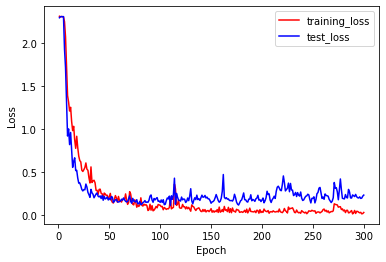

In [13]:
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
epoch_count = range(1, len(training_loss)+1)

training_acc = history.history["accuracy"]
test_acc = history.history["val_accuracy"]

plt.plot(epoch_count, training_loss, "r-")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["training_loss", "test_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('./figure/loss.png',dpi=300,bbox_inches='tight')

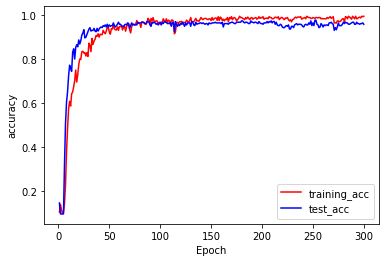

In [12]:
plt.plot(epoch_count, training_acc, "r-")
plt.plot(epoch_count, test_acc, "b-")
plt.legend(["training_acc", "test_acc"])
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.savefig('./figure/acc.png',dpi=300,bbox_inches='tight')

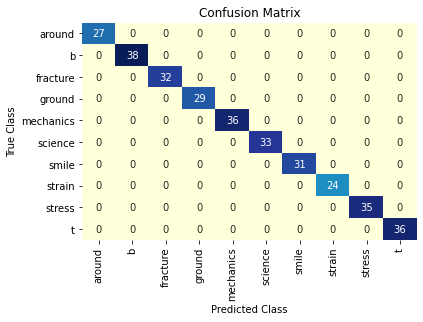

In [11]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

y_prediction = model.predict(X_test)

matrix = confusion_matrix(encoder.inverse_transform(y_test_raw), encoder.inverse_transform(np.argmax(y_prediction, axis=1)))


dataframe = pd.DataFrame(matrix, index = np.unique(label), columns=np.unique(label))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.savefig('./figure/heaat.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
print(score)

In [14]:
model.save("VGG.h5")

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 210, 210, 64)      5824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 210, 210, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 105, 105, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 105, 105, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 105, 105, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 52, 52, 256)       2